# Prepare

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Install

In [2]:
!pip install rdkit
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ray[tune]
!pip install discordwebhook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.8 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.3 MB/s eta 0:00:00


## Import

In [3]:
!git clone https://github.com/Sawahiko/SMILE_to_Feature

Cloning into 'SMILE_to_Feature'...
remote: Enumerating objects: 1642, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 1642 (delta 108), reused 266 (delta 107), pack-reused 1375
Receiving objects: 100% (1642/1642), 127.38 MiB | 28.21 MiB/s, done.
Resolving deltas: 100% (811/811), done.
Updating files: 100% (400/400), done.


In [4]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Machine Learning
## Algorithm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
## Tool, Error Metric
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from joblib import dump, load

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader
#import pytorch_lightning as L

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

#Deep Learning Add
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

## ML Algorithm

In [5]:
from sklearn.linear_model import LinearRegression
def Linear_default(x_train, y_train):
  lm = LinearRegression()
  lm.fit(x_train, y_train)
  return lm

from sklearn.linear_model import Ridge
def Ridge_default(x_train, y_train):
  ridge = Ridge()
  ridge.fit(x_train, y_train)
  return ridge

from sklearn.linear_model import Lasso
def Lasso_default(x_train, y_train):
  lasso = Lasso()
  lasso.fit(x_train, y_train)
  return lasso

from sklearn.tree import DecisionTreeRegressor
def DT_default(x_train, y_train):
  DT = DecisionTreeRegressor()
  DT.fit(x_train, y_train)
  return DT

from sklearn.ensemble import RandomForestRegressor
def RF_default(x_train, y_train):
  RF = RandomForestRegressor()
  RF.fit(x_train, y_train)
  return RF

def XGB_default(x_train, y_train):
  XGB = XGBRegressor()
  XGB.fit(x_train, y_train)
  return XGB

from sklearn.neighbors import KNeighborsRegressor
def KNN_default(x_train, y_train):
  KNN = KNeighborsRegressor()
  KNN.fit(x_train, y_train)
  return KNN

from sklearn.svm import SVR
def SVM_default(x_train, y_train):
  svr = SVR()
  svr.fit(x_train, y_train)
  return svr

## ML Algorithm for GridSearch

In [6]:
from sklearn.model_selection import GridSearchCV
def RF(x_train, y_train):
    # Parameter grid for Optimized Parameter
    # Default : n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=1.0
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': [None, 1, 'sqrt', 'log2'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model


def XGB(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : max_depth=None/6 , learning_rate=None   , n_estimators=None
    param_grid = {
        'max_depth': [None, 3, 4, 5, 6, 7],
        'learning_rate': [None, 0.01, 0.05, 0.1, 0.2],
        'n_estimators': [None, 100, 200, 300, 400]
    }

    xgb = XGBRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def DT(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : max_depth=None, min_samples_split=2,  min_samples_leaf=1
    param_grid = {
      'max_depth': [None, 3, 5, 7, 10],
      'min_samples_split': [2, 5, 10, 20],
      'min_samples_leaf': [1, 2, 5, 10]
    }

    dt = DecisionTreeRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(dt, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def KNN(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : n_neighbors=5, weights='uniform',  algorithm='auto'
    param_grid = {
      'n_neighbors': [5, 10, 20, 50],
      'weights': ['uniform', 'distance'],
      'algorithm': ['auto','ball_tree', 'kd_tree', 'brute']
    }

    knn = KNeighborsRegressor()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(knn, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def SVM_M(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : C=1, kernel='rbf',  degree=3, gamma='scale'
    param_grid = {
      'C': [0.1, 1, 10],
      'kernel': ['linear', 'rbf', 'poly'],
      'degree': [2, 3, 4],
      'gamma': ['scale', 0.01, 0.1, 0.3]
    }

    svr = SVR()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(svr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

## ML Algorithm for Select Best parameter

In [7]:
from sklearn.model_selection import GridSearchCV
#DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2)
#RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
#XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=200)
#KNeighborsRegressor(algorithm='brute', n_neighbors=50, weights='distance')

def RF_add(x_train, y_train):
    # Parameter grid for Optimized Parameter
    rf = RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model


def XGB_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 400]
    }

    xgb = XGBRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def DT_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
      'max_depth': [3, 5, 7, 10],
      'min_samples_split': [2, 5, 10, 20],
      'min_samples_leaf': [1, 2, 5, 10]
    }

    dt = DecisionTreeRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(dt, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def KNN_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
      'n_neighbors': [5, 10, 20, 50],
      'weights': ['uniform', 'distance'],
      'algorithm': ['ball_tree', 'kd_tree', 'brute']
    }

    knn = KNeighborsRegressor()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(knn, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model
def SVM_M_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
      'C': [0.1, 1, 10],
      'kernel': ['linear', 'rbf', 'poly'],
      'degree': [2, 3, 4],
      'gamma': [0.01, 0.1, 0.3]
    }

    svr = SVR()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(svr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

# Run Training

## Before

In [8]:
#%% Import Data
df = pd.read_csv("/content/SMILE_to_Feature/Second Semester/[Use] Main File/RDKit_CHON_New_Data_Psat_Not_Outliers.csv")
df = df[df['SMILES'] != "None"]
df = df.drop_duplicates(subset='SMILES').reset_index(drop=True)
df.sort_values(by="No.C")
#len(df["SMILES"].unique())

,Unnamed: 0,Column1,Name,SMILES,A,B,C,Tmin,Tmax,No.C,SMILES.1,Atom,Count Unique Atom,Pass Screen
0,0,0,Methanal,C=O,21.370292,2204.126554,-30.150,190,271,1,C=O,"[1, 6, 8]",3,True
868,874,1672,Methyl nitrite,CON=O,21.477846,2487.328403,-5.697,218,273,1,CON=O,"[1, 6, 7, 8]",4,True
1305,1314,2626,Methyl hydroperoxide,COO,24.159183,4521.153461,-0.696,243,323,1,COO,"[1, 6, 8]",3,True
15,15,28,Methanoic acid,C(=O)O,21.838546,3572.184462,-27.440,278,398,1,C(=O)O,"[1, 6, 8]",3,True
615,617,1144,Cyanic acid,C(#N)O,21.488023,2499.925846,-45.736,273,303,1,C(#N)O,"[1, 6, 7, 8]",4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,982,1938,1-Dodecyne,CCCCCCCCCCC#C,20.909177,3679.556307,-96.528,439,489,12,CCCCCCCCCCC#C,"[1, 6]",2,True
1460,1470,2913,Ethylene sebacate,C1CCCCC(=O)OCCOC(=O)CCC1,27.505415,8609.008762,-12.702,293,373,12,C1CCCCC(=O)OCCOC(=O)CCC1,"[1, 6, 8]",3,True
1462,1473,2919,Heptylcyclopentane,CCCCCCCC1CCCC1,20.951682,3850.382793,-88.750,377,529,12,CCCCCCCC1CCCC1,"[1, 6]",2,True
1696,1712,3479,3-Ethyldecane,CCCCCCCC(CC)CC,20.242878,3405.638482,-91.150,482,482,12,CCCCCCCC(CC)CC,"[1, 6]",2,True


In [9]:
# Genearate Temp in Tmin-Tmax and expand
df1 = df.copy()
    ## Function to generate equally distributed points
def generate_points(row, amount_point):
    start, end, num_points = row["Tmin"], row["Tmax"], amount_point
    step_size = (end - start) / (num_points - 1)
    return np.linspace(start, end, num_points)
df1["T"] = df1.apply(lambda x : generate_points(x, 2), axis=1)

df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
df1 = df1.reset_index(drop=True)

# Generate VP from Antione Coeff and Temp
def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))

df1["Vapor_Presssure"] = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])

# Get Needed Table and split for Training
df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
X_data= df2[["SMILES"]]               # feature: SMILE, T
Y_data= df2[["Vapor_Presssure"]]        # Target : Psat

In [10]:
# %% Fingerprint
# Parameter for Generate Morgan Fingerprint
MF_radius = 3;   MF_bit = 2048

# Generate Fingerprint from SMILE
X_data_use = X_data.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))    # Create Mol object from SMILES
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))         # Create Morgan Fingerprint from Mol object


# Transfrom Fingerprint to Datafrme that we can use for training
X_data_use["arr_count_morgan_fp"] = 0
X_data_fp = []
for i in range(X_data_use.shape[0]):
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)

# Final Data for Training
x_data_fp[MF_bit] = df2["T"]      # Input  = Fingerprint + Temp
y_data_fp = Y_data.copy()         # Output = Vapor Pressure

## Split

In [11]:
#%% Train-test split Data
x_train_fp, x_test_fp, y_train_fp, y_test_fp = train_test_split(x_data_fp, np.ravel(y_data_fp),test_size=0.2,random_state=42)

In [12]:
x_train_fp

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
3796,11.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,328.0
3041,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,454.0
605,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463.0
2274,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,366.0
1164,11.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,409.0
466,2.0,0.0,1.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0
3092,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0
3772,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,268.0


In [13]:
y_train_fp

array([ 2.57058946, 11.56288692, 12.26713606, ...,  3.64947379,
        7.60657909,  5.55116857])

## Training Function

In [14]:
#%% Training Model
from datetime import datetime

def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, all_time_fitting, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
  new_header = train_prediction_table.iloc[0] #grab the first row for the header
  train_prediction_table.columns = new_header #set the header row as the df header
  train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

  test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
  new_header = test_prediction_table.iloc[0] #grab the first row for the header
  test_prediction_table.columns = new_header #set the header row as the df header
  test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      time_start = datetime.now()
      model_train = list_model[iteration]
      name = name_model[iteration]
      if("DL" not in name):
        model_train.fit(X_train, y_train)
        y_train_pred = model_train.predict(X_train)
        y_test_pred  = model_train.predict(X_test)
      else:
        pass

      time_end = datetime.now()
      duration = (time_end - time_start).total_seconds()

      train_mae = mean_absolute_error(y_train, y_train_pred)
      train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
      train_r2 = r2_score(y_train, y_train_pred)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_r2 = r2_score(y_test, y_test_pred)

      results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2, duration]).transpose()
      results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']


      train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
      train_prediction_result.columns = ['Method','Training Predict','Training Actual']

      test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
      test_prediction_result.columns = ['Method','Test Predict','Test Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
      test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
  model_assess_table['Time Training'] = all_time_fitting
  return model_assess_table, train_prediction_table, test_prediction_table

# Inspect

In [15]:
xgb_test = XGBRegressor()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Inspect All ML Algorithm

## Training Setup & Run

In [21]:
# Specified model need to run
#names = ["XGB", "RF", "DL1", "DL2"]
#models = [XGB, RF, DL, DL2 ]

names = ["MLR", "Ridge", "Lasso", "DT", "RF", "XGB", "KNN", "SVM"]
models = [Linear_default, Ridge_default, Lasso_default, DT_default, RF_default, XGB_default, KNN_default, SVM_default]

# Run Training Model
all_result_model = []
all_time_fitting = []
for iteration in range(len(names)) :
    get_model = models[iteration]
    time_start = datetime.now()
    result_model = get_model(x_train_fp, y_train_fp)
    time_end = datetime.now()
    duration = (time_end - time_start).total_seconds()
    print(result_model)
    print(f'{duration} seconds')
    all_result_model.append(result_model)
    all_time_fitting.append(duration)

LinearRegression()
2.451494 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.04645e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge()
0.736533 seconds
Lasso()
0.987965 seconds
DecisionTreeRegressor()
0.872325 seconds
RandomForestRegressor()
37.781602 seconds
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
4.460253 seconds
KNeighborsRegressor()
0.03539 seconds
SVR()
18.205293 seconds


In [22]:
all_time_fitting

[2.451494,
 0.736533,
 0.987965,
 0.872325,
 37.781602,
 4.460253,
 0.03539,
 18.205293]

## Model Evaluation

In [23]:
# %% Model Evaluation
# Evaluate Model
result_evaluation, train_prediction, test_prediction = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, all_result_model, names, all_time_fitting)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.04645e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [24]:
result_evaluation

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate,Time Training
0,MLR,362.336708,603.615017,0.939114,6904.661659,32386.576786,-42664.420786,2.866393,2.451494
0,Ridge,118.032891,624.412806,0.934846,213.519937,787.075067,-24.198707,0.949045,0.736533
0,Lasso,97.518384,663.973412,0.926329,144.439844,942.88874,-35.163199,1.147478,0.987965
0,DT,0.0,0.0,1.0,1.307848,14.047567,0.991973,0.813091,0.872325
0,RF,9.544025,320.101482,0.982877,15.019701,405.733509,-5.696189,49.541748,37.781602
0,XGB,0.338267,0.523673,1.0,5.783608,156.480668,0.003982,3.332791,4.460253
0,KNN,49.088056,1957.16908,0.359893,50.424991,982.480308,-38.263919,2.329618,0.035390
0,SVM,61.720447,2446.942206,-0.00056,6.845613,156.846454,-0.00068,60.658979,18.205293


In [25]:
train_prediction

,Method,Training Predict,Training Actual
0,MLR,"[254.70087, -1006.7866, 958.5105, -30.03833, -...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,Ridge,"[-79.18787, -115.02426, 67.57654, -34.798065, ...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,Lasso,"[-58.864273, 80.99962, 109.55892, 45.826843, -...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,DT,"[2.5705894634589477, 11.562886924001367, 12.26...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,RF,"[3.174887243056245, 11.693322485466574, 12.024...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,XGB,"[3.3125083, 11.936513, 11.541054, 7.789337, 2....","[2.5705894634589477, 11.562886924001367, 12.26..."
0,KNN,"[5.531486774747218, 11.530686822228704, 11.805...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,SVM,"[8.053925769944028, 11.283338221734791, 11.459...","[2.5705894634589477, 11.562886924001367, 12.26..."


In [26]:
test_prediction

,Method,Test Predict,Test Actual
0,MLR,"[176.34198, -19.0177, 435.19495, 125609.445, 6...","[5.058023855700991, 11.420978525249815, 11.542..."
0,Ridge,"[-3.1802063, 61.798218, 196.49425, 16.138672, ...","[5.058023855700991, 11.420978525249815, 11.542..."
0,Lasso,"[-99.93294, 14.856506, -65.58716, -18.094727, ...","[5.058023855700991, 11.420978525249815, 11.542..."
0,DT,"[6.992981370123634, 11.558225947154183, 11.529...","[5.058023855700991, 11.420978525249815, 11.542..."
0,RF,"[6.304556811053877, 11.583680576204303, 11.441...","[5.058023855700991, 11.420978525249815, 11.542..."
0,XGB,"[6.3986554, 11.405404, 11.651344, 7.7516346, 7...","[5.058023855700991, 11.420978525249815, 11.542..."
0,KNN,"[6.274329752976347, 11.752773693512086, 11.616...","[5.058023855700991, 11.420978525249815, 11.542..."
0,SVM,"[9.085418231660183, 11.28387515609177, 11.8134...","[5.058023855700991, 11.420978525249815, 11.542..."


In [27]:
result_evaluation = result_evaluation.reset_index(drop=True)
train_prediction = train_prediction.reset_index(drop=True).explode(['Training Predict', 'Training Actual'])
test_prediction = test_prediction.reset_index(drop=True).explode(['Test Predict', 'Test Actual'])

# Change datatype
def change_data_type(x):
  return float(x)

test_prediction['Test Predict'] = test_prediction['Test Predict'].apply(lambda x: change_data_type(x))
train_prediction['Training Predict'] = train_prediction['Training Predict'].apply(lambda x: change_data_type(x))

## Inspect

In [28]:
x_train_fp[MF_bit]
y_train_fp.shape

(3601,)

In [42]:
all_result_model

[LinearRegression(),
 Ridge(),
 Lasso(),
 DecisionTreeRegressor(),
 RandomForestRegressor(),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 KNeighborsRegressor(),
 SVR()]

In [30]:
result_evaluation

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate,Time Training
0,MLR,362.336708,603.615017,0.939114,6904.661659,32386.576786,-42664.420786,2.866393,2.451494
1,Ridge,118.032891,624.412806,0.934846,213.519937,787.075067,-24.198707,0.949045,0.736533
2,Lasso,97.518384,663.973412,0.926329,144.439844,942.88874,-35.163199,1.147478,0.987965
3,DT,0.0,0.0,1.0,1.307848,14.047567,0.991973,0.813091,0.872325
4,RF,9.544025,320.101482,0.982877,15.019701,405.733509,-5.696189,49.541748,37.781602
5,XGB,0.338267,0.523673,1.0,5.783608,156.480668,0.003982,3.332791,4.460253
6,KNN,49.088056,1957.16908,0.359893,50.424991,982.480308,-38.263919,2.329618,0.035390
7,SVM,61.720447,2446.942206,-0.00056,6.845613,156.846454,-0.00068,60.658979,18.205293


In [31]:
test_prediction.shape[0]/4

1802.0

In [32]:
train_prediction.shape[0]/4

7202.0

## Visualization

(-518149.15625, 146806.5)

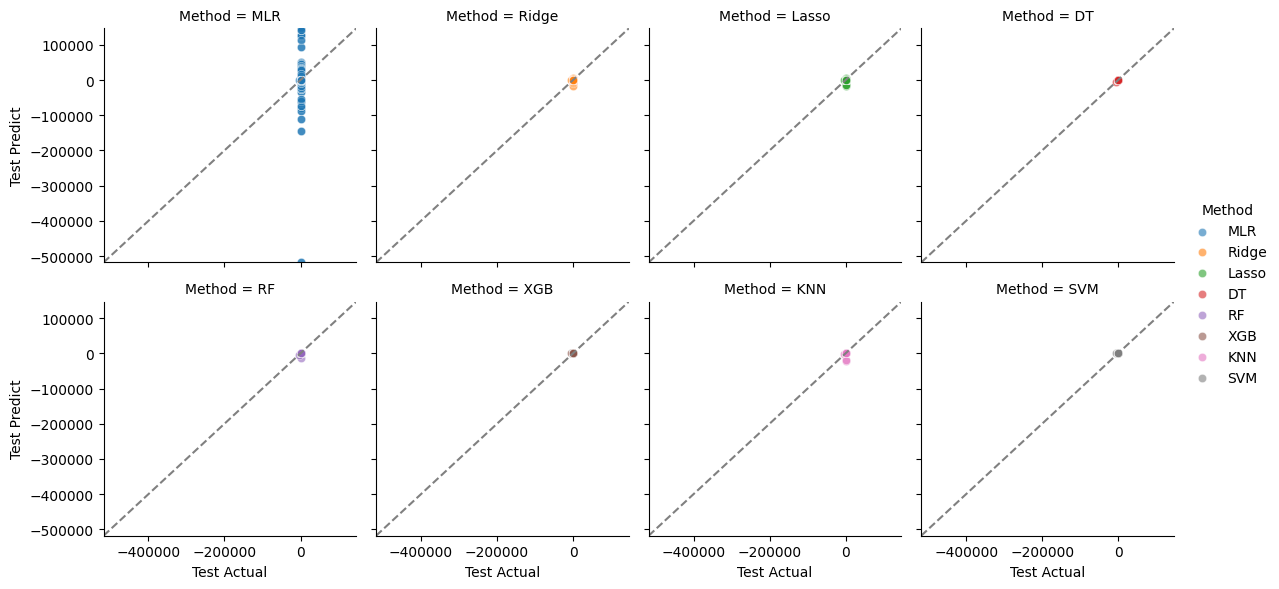

In [33]:
#%% Visualization
# Specified Range for plot
x_min = min(min(test_prediction["Test Predict"]),min(test_prediction["Test Actual"]))-20
x_max = max(max(test_prediction["Test Predict"]),max(test_prediction["Test Actual"]))+20
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

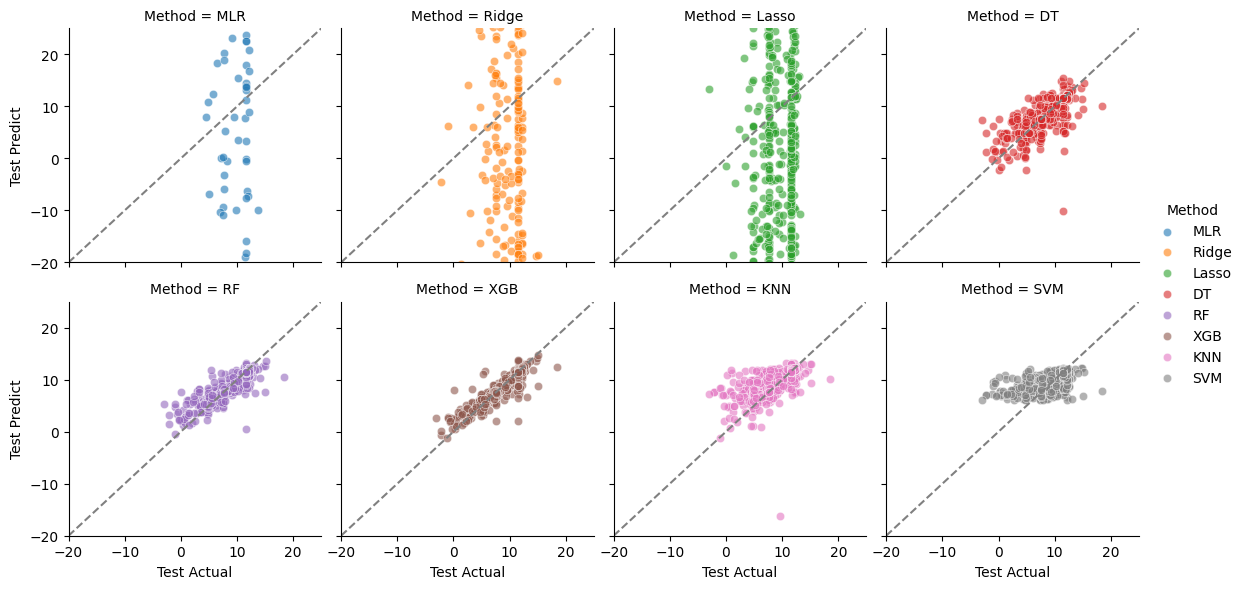

In [34]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Inspect Best ML Algorithm

## Training Setup & Run

In [ ]:
# Specified model need to run
#names_bestpar = ["RF"]
#models_bestpar = [SVM_M]

#names_bestpar = ["DT", "RF", "XGB", "KNN", "SVM"]
#models_bestpar = [DT, RF, XGB, KNN, SVM_M]

names_bestpar = ["DT", "SVM"]
models_bestpar = [DT, SVM_M]
# Run Training Model
all_result_model_bestpar = []
all_time_fitting_bestpar = []
for iteration in range(len(names_bestpar)) :
    get_model = models_bestpar[iteration]
    time_start = datetime.now()
    result_model = get_model(x_train_fp, y_train_fp)
    time_end = datetime.now()
    duration = (time_end - time_start).total_seconds()
    print(f'{duration} seconds')
    all_result_model_bestpar.append(result_model)
    all_time_fitting_bestpar.append(duration)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
78.974443 seconds


In [ ]:
all_time_fitting_bestpar

## Model Evaluation

In [ ]:
# for Add
names_bestpar = ["DT", "RF", "XGB", "KNN"]
all_time_fitting_bestpar = [78.974443, 11156.308995, 2246.572729, 224.646208]
all_result_model_bestpar =[
    DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2).fit(x_train_fp, y_train_fp),
    RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200).fit(x_train_fp, y_train_fp),
    XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=200).fit(x_train_fp, y_train_fp),
    KNeighborsRegressor(algorithm='brute', n_neighbors=50, weights='distance').fit(x_train_fp, y_train_fp),
]

In [ ]:
# for Add
#names_bestpar = ["RF_default", "RF"]
#all_time_fitting_bestpar = [ 40.522611, 11156.308995]
'''
all_result_model_bestpar =[
    RandomForestRegressor().fit(x_train_fp, y_train_fp),
    RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200).fit(x_train_fp, y_train_fp),

]
'''

'\nall_result_model_bestpar =[\n    RandomForestRegressor().fit(x_train_fp, y_train_fp),\n    RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200).fit(x_train_fp, y_train_fp),\n    \n]\n'

In [ ]:
# %% Model Evaluation
# Evaluate Model
result_evaluation_bestpar, train_prediction_bestpar, test_prediction_bestpar = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, all_result_model_bestpar, names_bestpar, all_time_fitting_bestpar)

In [ ]:
result_evaluation_bestpar

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate,Time Training
0,DT,1.201507,1.843883,0.999999,1.351046,2.341155,0.999777,0.296088,78.974443
0,RF,11.904361,352.976854,0.97918,13.858447,333.544837,-3.525373,17.326658,11156.308995
0,XGB,1.884192,10.86446,0.99998,6.88938,115.311553,0.459132,5.143674,2246.572729
0,KNN,0.0,0.0,1.0,43.679101,303.384599,-2.743976,2.436111,224.646208


In [ ]:
train_prediction_bestpar

,Method,Training Predict,Training Actual
0,DT,"[4.10072786286239, 11.280749540823587, 10.3145...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,RF,"[6.8408607902356335, 11.143153501085342, 11.12...","[2.5705894634589477, 11.562886924001367, 12.26..."
0,XGB,"[7.239415, 11.051113, 10.751758, 8.2278385, 7....","[2.5705894634589477, 11.562886924001367, 12.26..."
0,KNN,"[2.5705894634589477, 11.562886924001367, 12.26...","[2.5705894634589477, 11.562886924001367, 12.26..."


In [ ]:
test_prediction_bestpar

,Method,Test Predict,Test Actual
0,DT,"[7.744068436274705, 11.280749540823587, 11.280...","[5.058023855700991, 11.420978525249815, 11.542..."
0,RF,"[7.1251157971696735, 11.143153501085342, 11.12...","[5.058023855700991, 11.420978525249815, 11.542..."
0,XGB,"[7.6527967, 11.051113, 10.384523, 7.7422223, 7...","[5.058023855700991, 11.420978525249815, 11.542..."
0,KNN,"[5.023312041532692, 11.68908043369049, 11.1627...","[5.058023855700991, 11.420978525249815, 11.542..."


In [ ]:
result_evaluation_bestpar = result_evaluation_bestpar.reset_index(drop=True)
train_prediction_bestpar = train_prediction_bestpar.reset_index(drop=True).explode(['Training Predict', 'Training Actual'])
test_prediction_bestpar = test_prediction_bestpar.reset_index(drop=True).explode(['Test Predict', 'Test Actual'])

# Change datatype
def change_data_type(x):
  return float(x)

test_prediction_bestpar['Test Predict'] = test_prediction_bestpar['Test Predict'].apply(lambda x: change_data_type(x))
train_prediction_bestpar['Training Predict'] = train_prediction_bestpar['Training Predict'].apply(lambda x: change_data_type(x))

## Inspect

In [ ]:
x_train_fp[MF_bit]
y_train_fp.shape

In [ ]:
all_result_model_bestpar

In [ ]:
result_evaluation_bestpar

In [ ]:
test_prediction_bestpar.shape[0]/4

In [ ]:
train_prediction_bestpar.shape[0]/4

## Visualization

(-9964.509160715466, 38.43556183833226)

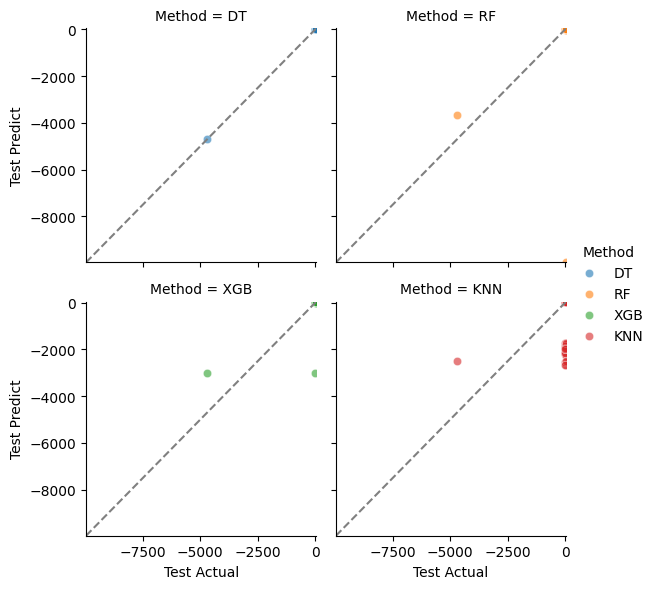

In [ ]:
#%% Visualization
# Specified Range for plot
x_min = min(min(test_prediction_bestpar["Test Predict"]),min(test_prediction_bestpar["Test Actual"]))-20
x_max = max(max(test_prediction_bestpar["Test Predict"]),max(test_prediction_bestpar["Test Actual"]))+20
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction_bestpar, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

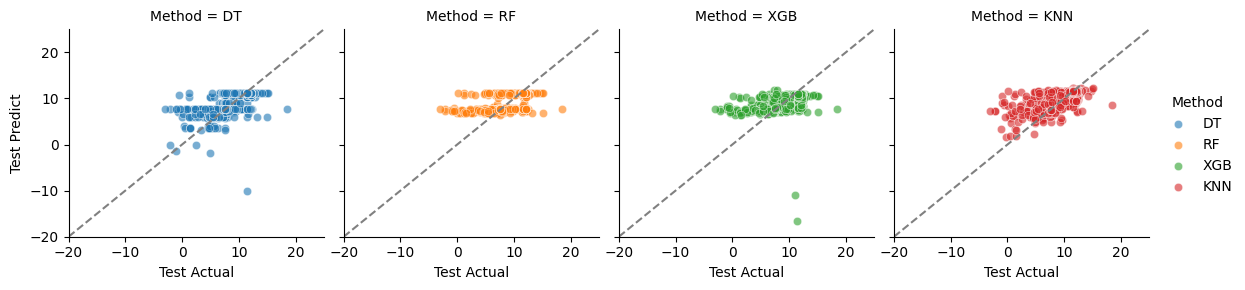

In [ ]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction_bestpar, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

## Send Line

In [ ]:
import requests
url = 'https://notify-api.line.me/api/notify'
token = '3CfMWfczpal9Zye6bD72a8Ud6FWOODnBHQZHIWM1YU4'
headers = {'content-type':'application/x-www-form-urlencoded','Authorization':'Bearer '+token}

msg = f'run ML Hyperparameter เสร็จแล้ว'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

In [ ]:

from discordwebhook import Discord
discord_sky = Discord(url="https://discord.com/api/webhooks/1199614974293717103/TBi5ecy1kOZoE1bOfiHoeygsRFS1DTIp-2-f4RjSaqLbQwBki6g7M2baYJX88igNBre9")
discord_sky.post(content="Run เสร็จแล้ว")

# Save Result, Model

## Set up for Save

In [ ]:
# Set up
import datetime
#date_run = datetime.now().strftime("%Y-%m-%d")
date_run = "2024-01-17"
# Result Path
result_path1 = f"{date_run} Psat Psat SMILES T VP.csv"
result_path2 = f"{date_run} Psat Psat test_prediction.csv"
result_path3 = f"{date_run} Psat Psat train_prediction.csv"
result_path4 = f"{date_run} Psat Psat result_evaluation.csv"

# Model Path
all_path_export = []
for name in names:
  name_model = name
  model_template1 = f" Psat Psat {name_model}.joblib"
  model_template2 = f" Psat Psat {name_model}.pth"

  path_export = ""
  if("DL" not in name_model):
    path_export = model_template1
  else:
    path_export = model_template2
  path_export = date_run+path_export
  all_path_export.append(path_export)

## Set Up Download to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Result path
com_path = "/content/gdrive/MyDrive/for_ML-Project/For Save/"

com_result_path1 = com_path+ result_path1
com_result_path2 = com_path+ result_path2
com_result_path3 = com_path+ result_path3
com_result_path4 = com_path+ result_path4

## Model path
drive_model_all_path_export = []
for path_save in all_path_export:
  drive_export = com_path+path_save
  drive_model_all_path_export.append(drive_export)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Save & Download to Computer

### Save

In [ ]:
# Save Result
df2.to_csv(result_path1)
test_prediction.to_csv(result_path2)
train_prediction.to_csv(result_path3)
result_evaluation.to_csv(result_path4)

In [ ]:
# Save Model
for i in range(len(all_path_export)):
  name = names[i]
  model_export = all_result_model[i]
  path = all_path_export[i]

  if("DL" not in name):
    dump(model_export, path)
  else:
    torch.save(model_export.state_dict(), path)
#loaded_model = load("my_model.joblib")

In [ ]:
msg = f'Save เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


### Download to computer

In [ ]:
all_path_export

['2024-01-17 Psat Psat RF.joblib']

In [ ]:
from google.colab import files
# Download Result
files.download(result_path2)
files.download(result_path3)
files.download(result_path4)

# Download Model
for path in all_path_export:
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
msg = f'download ลง คอม เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


## Save to Drive

### Save

In [ ]:
# Save Result to Drive
df2.to_csv(com_result_path1)
test_prediction.to_csv(com_result_path2)
train_prediction.to_csv(com_result_path3)
result_evaluation.to_csv(com_result_path4)

In [ ]:
# Save Model
for i in range(len(drive_model_all_path_export)):
  name = names[i]
  model_export = all_result_model[i]
  path = drive_model_all_path_export[i]

  if("DL" not in name):
    dump(model_export, path)
  else:
    torch.save(model_export.state_dict(), path)
#loaded_model = load("my_model.joblib")

In [ ]:
msg = f'download ลง drive เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


# Visualization From File

In [ ]:
# Get result from Model that just got
test_prediction = pd.read_csv("/content/2024-01-03 Psat Psat test_prediction.csv")
train_prediction = pd.read_csv("/content/2024-01-03 Psat Psat train_prediction.csv")
result_evaluation = pd.read_csv("/content/2024-01-03 Psat Psat result_evaluation.csv")

# Get result from Github
#test_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat test_prediction.csv")
#train_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat train_prediction.csv")
#result_evaluation = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat result_evaluation.csv")

In [ ]:
# Change Data that can show Error Metric in each plot
result_evaluation_merge = result_evaluation[["Method","Test RMSE", "Test R2"]]
merged_df = test_prediction.merge(result_evaluation_merge, on='Method', how='inner')  # Inner join
merged_df

,Unnamed: 0,Method,Test Predict,Test Actual,Test RMSE,Test R2
0,0,XGB,10.007981,8.397664,78.518016,-0.060755
1,0,XGB,8.948020,7.725961,78.518016,-0.060755
2,0,XGB,8.671771,1.416442,78.518016,-0.060755
3,0,XGB,8.948020,5.016796,78.518016,-0.060755
4,0,XGB,8.968746,7.362200,78.518016,-0.060755
...,...,...,...,...,...,...
15267,3,DL2,-17.290596,1.133479,75.797770,0.011471
15268,3,DL2,11.440319,8.319116,75.797770,0.011471
15269,3,DL2,9.888784,11.073348,75.797770,0.011471
15270,3,DL2,11.448484,8.341905,75.797770,0.011471


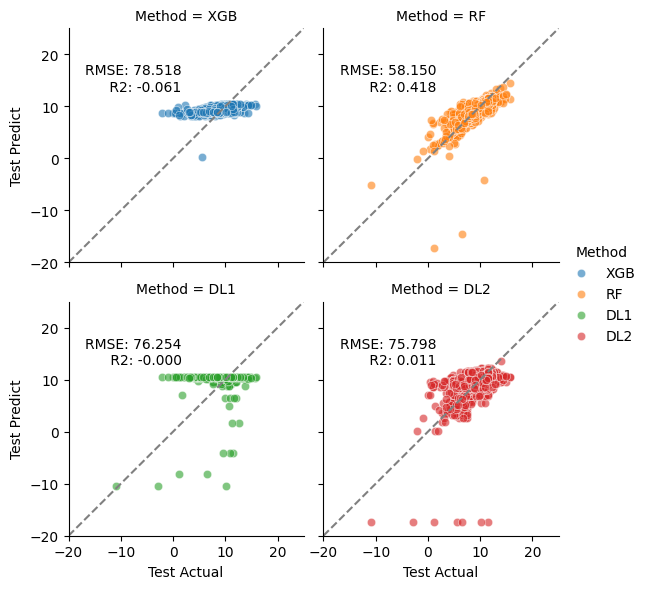

In [ ]:
# Specified Range for plot
x_min = -20; x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(merged_df, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)

# Insert Perfect Line and Error Metric
def plot_with_text2(data, **kws):
    plt.axline((0, 0), slope=1, color='.5', linestyle='--')
    # Access the current subplot and add text
    current_ax = plt.gca()
    current_ax.text(0.5, 0.85, f"RMSE: {data['Test RMSE'].iloc[0]:.3f} \n R2: {data['Test R2'].iloc[0]:.3f} ",
                    transform=current_ax.transAxes, ha='right', va='top')
g.map_dataframe(plot_with_text2)

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# ABC From File

In [ ]:
# Get result from Github
ML_model = load("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-03 Psat Psat RF.joblib")
all_result_model = [ML_model]
names = ["RF"]

In [ ]:
#%% Training Model

def model_assess2(X_all, y_all, list_model, name_model, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','MAE', 'RMSE','R2']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  prediction_table = pd.DataFrame(['Method','Predict','Actual']).transpose()
  new_header = prediction_table.iloc[0] #grab the first row for the header
  prediction_table.columns = new_header #set the header row as the df header
  prediction_table.drop(index=prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      model = list_model[iteration]
      name = name_model[iteration]
      if("DL" not in name):
        model.fit(X_all, y_all)
        y_pred = model.predict(X_all)
      else:
        X_drop = X_all.drop(columns=X_all.shape[1]-1)
        y_pred = model(torch.tensor(X_drop.values)).detach().numpy()

      mae = mean_absolute_error(y_all, y_pred)
      rmse = mean_squared_error(y_all, y_pred, squared=False)
      r2 = r2_score(y_all, y_pred)

      results = pd.DataFrame([name_model[iteration],mae, rmse, r2]).transpose()
      results.columns = ['Method','MAE', 'RMSE','R2']

      prediction_result = pd.DataFrame([name_model[iteration],y_pred, y_all]).transpose()
      prediction_result.columns = ['Method','Predict','Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      prediction_table = pd.concat([prediction_table, prediction_result])
  return model_assess_table, prediction_table

In [ ]:
result_evaluation, prediction = model_assess2(x_data_fp, y_data_fp, all_result_model, names)
result_evaluation = result_evaluation.reset_index(drop=True)
prediction = prediction.reset_index(drop=True).explode(['Predict', 'Actual'])


# Change datatype
def change_data_type(x):
  return float(x)

prediction['Predict'] = prediction['Predict'].apply(lambda x: change_data_type(x))
prediction = prediction.reset_index()

In [ ]:
temp = prediction[["Predict"]].reset_index(drop=True)
df3 = df2.copy()
df3 = pd.concat([df3, temp], axis = 1)
df4 = df3.copy()
df4 = df3.groupby('SMILES', sort=False, dropna=False)['T'].apply(list)
df4

SMILES
C=O                          [190.0, 199.0, 208.0, 217.0, 226.0, 235.0, 244...
CCOC(=O)N                    [338.0, 351.22222900390625, 364.4444580078125,...
CN1CCC[C@H]1C2=CN=CC=C2      [334.0, 354.77777099609375, 375.5555419921875,...
C(C(CO)O)O                   [341.0, 365.6666564941406, 390.3333435058594, ...
CN(C)N                       [238.0, 244.11111450195312, 250.22222900390625...
                                                   ...                        
CC(C)OCC(C)OCC(C)OCC(C)O     [355.0, 374.3333435058594, 393.6666564941406, ...
CCCO[Ge](OCCC)(OCCC)OCCC     [343.0, 355.22222900390625, 367.4444580078125,...
CC(C(=O)OC(C)C(=O)OC)O       [317.0, 324.4444580078125, 331.8888854980469, ...
CCCCOC(=O)C(C)OC(=O)C        [331.0, 348.1111145019531, 365.22222900390625,...
CCCCOC(=O)C(C)OC(=O)C(C)O    [324.0, 333.22222900390625, 342.4444580078125,...
Name: T, Length: 1899, dtype: object

In [ ]:
result = df3.groupby('SMILES', sort=False)[['T', 'Vapor_Presssure', 'Predict']].agg(list)
# Reset the index to create a DataFrame
result = result.reset_index()
result

,SMILES,T,Vapor_Presssure,Predict
0,C=O,"[190.0, 199.0, 208.0, 217.0, 226.0, 235.0, 244...","[7.581574364482325, 8.316537118226234, 8.97711...","[8.08563462739309, 8.49993187840082, 8.9514968..."
1,CCOC(=O)N,"[338.0, 351.22222900390625, 364.4444580078125,...","[6.428062761494029, 7.192461455697213, 7.89259...","[6.640493598558538, 7.319272393386114, 8.00254..."
2,CN1CCC[C@H]1C2=CN=CC=C2,"[334.0, 354.77777099609375, 375.5555419921875,...","[4.848526499977353, 5.986162236744422, 6.98182...","[5.133536107619277, 6.207200197926775, 7.42523..."
3,C(C(CO)O)O,"[341.0, 365.6666564941406, 390.3333435058594, ...","[0.6415754658113535, 2.694676143579546, 4.4201...","[2.034855515702384, 3.6366866795282657, 5.1631..."
4,CN(C)N,"[238.0, 244.11111450195312, 250.22222900390625...","[6.166674419597758, 6.653305107846041, 7.11157...","[6.5096126852342175, 6.623706343938554, 7.0321..."
...,...,...,...,...
1894,CC(C)OCC(C)OCC(C)OCC(C)O,"[355.0, 374.3333435058594, 393.6666564941406, ...","[4.881800031308973, 5.92654046864067, 6.866759...","[5.140893384594914, 6.096777891998492, 6.96473..."
1895,CCCO[Ge](OCCC)(OCCC)OCCC,"[343.0, 355.22222900390625, 367.4444580078125,...","[4.445406432309333, 5.2158210969216725, 5.9264...","[4.794788527120863, 5.323107795268345, 6.11472..."
1896,CC(C(=O)OC(C)C(=O)OC)O,"[317.0, 324.4444580078125, 331.8888854980469, ...","[2.5812522706303724, 3.223757326560456, 3.8266...","[3.013679000518691, 3.435888068820115, 4.09231..."
1897,CCCCOC(=O)C(C)OC(=O)C,"[331.0, 348.1111145019531, 365.22222900390625,...","[4.928566362502519, 6.128070798648743, 7.14648...","[5.04730002802046, 6.305584380659897, 7.179396..."


In [ ]:
x = result["T"].apply(lambda num: [1/num1 for num1 in num])
y = result["Predict"]

xy_table = pd.DataFrame({
    "x" : x,
    "y" : y})

result2 = result.join(xy_table)
#%%
from scipy.optimize import curve_fit
def objective(X, a, b, c):
    x,y = X
    # Linearized Equation : y + C * y * x1 = A + B * x1
    # return a +(b*x) - (c*y*x)

    # Linearized Equation : logP = A + (AC-B) (1/T) +  (-C) (logP /T)
    a0 = a
    a1 = a*c - b
    a2 = -c
    x1 = x
    x2 = y*x
    return a0 + a1*x1 + a2*x2

def getABC(row):
    #print(row.x)
    x1 = row.x
    y1 = row.y
    popt, _ = curve_fit(objective, (x1,y1), y1)
    a,b,c = popt
    return [a,b,c]
#z = func((x,y), a, b, c) * 1
result2["ABC"] = result2.apply(getABC, axis=1)
result2[['A_Pred', 'B_Pred', 'C_Pred']] = pd.DataFrame(result2['ABC'].tolist())


x_test = result["T"].apply(lambda num: [1/num1 for num1 in num])
y_test = result["Vapor_Presssure"]
xy_test_table = pd.DataFrame({
    "x_test" : x_test,
    "y_test" : y_test})
result2 = result2.join(xy_test_table)
def getABC2(row):
    #print(row.x)
    x1 = row.x_test
    y1 = row.y_test
    popt, _ = curve_fit(objective, (x1,y1), y1, method="dogbox")
    a,b,c = popt
    return [a,b,c]
result2["ABC_test"] = result2.apply(getABC2, axis=1)
result2[['A_test', 'B_test', 'C_test']] = pd.DataFrame(result2['ABC_test'].tolist())
result2.head(3)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,SMILES,T,Vapor_Presssure,Predict,x,y,ABC,A_Pred,B_Pred,C_Pred,x_test,y_test,ABC_test,A_test,B_test,C_test
0,C=O,"[190.0, 199.0, 208.0, 217.0, 226.0, 235.0, 244...","[7.581574364482325, 8.316537118226234, 8.97711...","[8.08563462739309, 8.49993187840082, 8.9514968...","[0.005263157894736842, 0.005025125628140704, 0...","[8.08563462739309, 8.49993187840082, 8.9514968...","[17.642868405615147, 1182.8598673800616, -69.4...",17.642868,1182.859867,-69.463837,"[0.005263157894736842, 0.005025125628140704, 0...","[7.581574364482325, 8.316537118226234, 8.97711...","[21.370292249338135, 2204.1265538212515, -30.1...",21.370292,2204.126554,-30.150
1,CCOC(=O)N,"[338.0, 351.22222900390625, 364.4444580078125,...","[6.428062761494029, 7.192461455697213, 7.89259...","[6.640493598558538, 7.319272393386114, 8.00254...","[0.0029585798816568047, 0.0028472001981084123,...","[6.640493598558538, 7.319272393386114, 8.00254...","[21.450280435207972, 3761.3436627822102, -84.5...",21.450280,3761.343663,-84.500079,"[0.0029585798816568047, 0.0028472001981084123,...","[6.428062761494029, 7.192461455697213, 7.89259...","[23.84683764449035, 5018.000670035375, -49.919...",23.846838,5018.000670,-49.920
2,CN1CCC[C@H]1C2=CN=CC=C2,"[334.0, 354.77777099609375, 375.5555419921875,...","[4.848526499977353, 5.986162236744422, 6.98182...","[5.133536107619277, 6.207200197926775, 7.42523...","[0.0029940119760479044, 0.002818665885386067, ...","[5.133536107619277, 6.207200197926775, 7.42523...","[19.238281010142614, 3013.015645100715, -121.7...",19.238281,3013.015645,-121.737979,"[0.0029940119760479044, 0.002818665885386067, ...","[4.848526499977353, 5.986162236744422, 6.98182...","[21.942530703904826, 4981.654364988623, -42.57...",21.942531,4981.654365,-42.573


In [ ]:
result3 = result2[["SMILES", "A_Pred", "B_Pred", "C_Pred", "A_test", "B_test", "C_test"]]
df_for_lookup = df[["SMILES","A", 'B', "C"]]
final = pd.concat([result3, df_for_lookup[["A", "B", "C"]]], axis=1)
print(final.describe())
final

            A_Pred        B_Pred       C_Pred       A_test       B_test  \
count  1899.000000   1899.000000  1899.000000  1899.000000  1899.000000   
mean     16.785065   2110.406758  -144.310412    20.087967  3296.074107   
std       6.217676   2168.883106   137.210419     4.108141  1858.104718   
min     -23.041112 -16383.000000  -681.667399     9.537105     0.964268   
25%      13.141839    395.764163  -199.730589    20.541408  2723.405440   
50%      18.857844   2255.244199  -107.202545    20.916107  3358.780875   
75%      20.722021   3260.900323   -58.006761    22.349513  4415.432568   
max      34.507058  15254.949337   257.000000    27.048467  7102.717471   

             C_test            A            B            C  
count  1.899000e+03  1899.000000  1899.000000  1899.000000  
mean  -4.639798e+01    21.565060  3838.133069   -59.844509  
std    3.763382e+01     1.583863  1168.597268    32.692252  
min   -1.475500e+02    16.219064   911.234235  -147.550000  
25%   -6.877000e+01

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C
0,C=O,17.642868,1182.859867,-69.463837,21.370292,2204.126554,-30.150000,21.370292,2204.126554,-30.150
1,CCOC(=O)N,21.450280,3761.343663,-84.500079,23.846838,5018.000670,-49.920000,23.846838,5018.000667,-49.920
2,CN1CCC[C@H]1C2=CN=CC=C2,19.238281,3013.015645,-121.737979,21.942531,4981.654365,-42.573000,21.942531,4981.654362,-42.573
3,C(C(CO)O)O,22.780799,5552.565710,-74.235884,24.322575,6153.389234,-81.155001,24.322575,6153.389259,-81.155
4,CN(C)N,9.462657,23.056457,-237.851005,22.379838,3202.002456,-40.506000,22.379838,3202.002461,-40.506
...,...,...,...,...,...,...,...,...,...,...
1894,CC(C)OCC(C)OCC(C)OCC(C)O,20.272266,3678.429670,-113.938803,24.722672,6901.250470,-7.170000,24.722672,6901.250476,-7.170
1895,CCCO[Ge](OCCC)(OCCC)OCCC,22.854579,5189.286953,-57.809433,23.539143,5550.358348,-52.310000,23.539143,5550.358341,-52.310
1896,CC(C(=O)OC(C)C(=O)OC)O,14.733064,1448.504308,-195.155641,22.802385,4587.163997,-90.149999,22.802385,4587.163971,-90.150
1897,CCCCOC(=O)C(C)OC(=O)C,18.162353,2173.813661,-165.678623,19.619269,2827.284491,-138.545995,19.619268,2827.284368,-138.546


In [ ]:
temp = result.iloc[0]
#print(temp)
temp_df = pd.DataFrame({
    "T":temp["T"]
    ,"Acutal Psat": temp["Vapor_Presssure"]
    ,"Predict Psat": temp["Predict"]
})
print(temp_df.describe())
temp_df.head()

                T  Acutal Psat  Predict Psat
count   10.000000    10.000000     10.000000
mean   230.500000    10.180152     10.099330
std     27.248853     1.552375      1.314651
min    190.000000     7.581574      8.085635
25%    210.250000     9.126351      9.084432
50%    230.500000    10.363359     10.196425
75%    250.750000    11.375601     11.202697
max    271.000000    12.218843     11.754274


,T,Acutal Psat,Predict Psat
0,190.0,7.581574,8.085635
1,199.0,8.316537,8.499932
2,208.0,8.977115,8.951497
3,217.0,9.574057,9.483237
4,226.0,10.116136,9.945203


(2.581574364482325, 17.21884299112518)

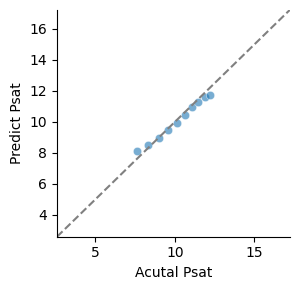

In [ ]:
#%% Visualization
# Specified Range for plot
x_min = min(min(temp_df["Predict Psat"]),min(temp_df["Acutal Psat"]))-5
x_max = max(max(temp_df["Predict Psat"]),max(temp_df["Acutal Psat"]))+5
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(temp_df)
g.map_dataframe(sns.scatterplot, x="Acutal Psat", y="Predict Psat", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [ ]:
temp_df

,T,Acutal Psat,Predict Psat
0,190.0,7.581574,8.085635
1,199.0,8.316537,8.499932
2,208.0,8.977115,8.951497
3,217.0,9.574057,9.483237
4,226.0,10.116136,9.945203
5,235.0,10.610582,10.447647
6,244.0,11.063411,10.942907
7,253.0,11.479664,11.289293
8,262.0,11.863600,11.593675
9,271.0,12.218843,11.754274
